In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

In [2]:
# Downloading SPY and GLD
end = datetime.today()
start = end - timedelta(days = 365*15)

tickers = ['SPY', 'GLD']

data = web.DataReader(tickers, 'yahoo', start, end)['Adj Close']

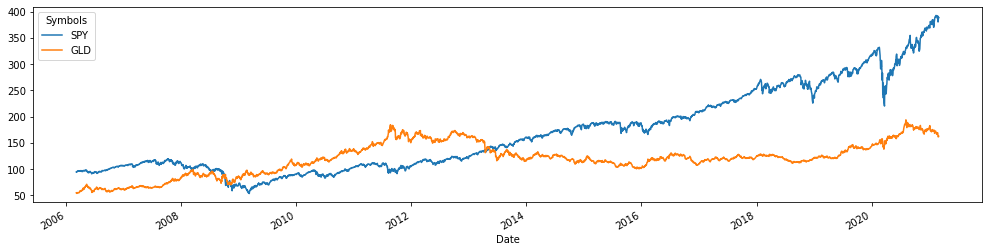

In [3]:
#Plotting the price
data.plot(figsize = (17,4))
plt.show()

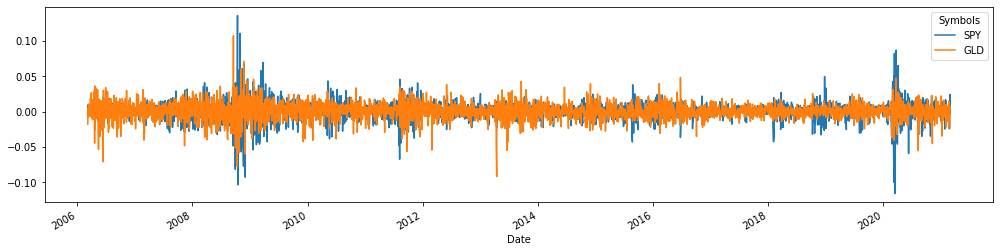

In [4]:
#Ploting the returns
returns = np.log(data).diff()[1:]
returns.plot(figsize = (17,4))
plt.show()

In [5]:
returns.std()

Symbols
SPY    0.012701
GLD    0.011671
dtype: float64

In [6]:
#Weight of assets in portfolio
weight1 = np.linspace(0.01,0.99,99)
weight2 = 1 - weight1

In [7]:
dataset = data.copy()
asset1, asset2 = dataset['SPY'], dataset['GLD']
for i in range(len(weight1)):
    dataset = pd.concat((dataset, (weight1[i]*asset1 + weight2[i]*asset2)), axis = 'columns')
dataset.columns = ['Weight1 = 1', 'Weight1 = 0'] + ['Weight1 ='+str(round(i,2)) for i in weight1]
dataset = dataset[['Weight1 = 0'] + ['Weight1 ='+str(round(i,2)) for i in weight1] + ['Weight1 = 1']]

In [8]:
dataset.head()

,Weight1 = 0,Weight1 =0.01,Weight1 =0.02,Weight1 =0.03,Weight1 =0.04,Weight1 =0.05,Weight1 =0.06,Weight1 =0.07,Weight1 =0.08,Weight1 =0.09,...,Weight1 =0.91,Weight1 =0.92,Weight1 =0.93,Weight1 =0.94,Weight1 =0.95,Weight1 =0.96,Weight1 =0.97,Weight1 =0.98,Weight1 =0.99,Weight1 = 1
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-07,54.950001,55.346856,55.743710,56.140565,56.537420,56.934275,57.331130,57.727985,58.124839,58.521694,...,91.063789,91.460644,91.857499,92.254354,92.651209,93.048064,93.444918,93.841773,94.238628,94.635483
2006-03-08,53.970001,54.378653,54.787305,55.195956,55.604608,56.013260,56.421911,56.830563,57.239214,57.647866,...,91.157302,91.565954,91.974605,92.383257,92.791909,93.200560,93.609212,94.017864,94.426515,94.835167
2006-03-09,54.240002,54.639593,55.039185,55.438777,55.838368,56.237960,56.637551,57.037143,57.436735,57.836326,...,90.602841,91.002432,91.402024,91.801616,92.201207,92.600799,93.000390,93.399982,93.799574,94.199165
2006-03-10,53.830002,54.242641,54.655281,55.067920,55.480559,55.893199,56.305838,56.718478,57.131117,57.543756,...,91.380186,91.792826,92.205465,92.618104,93.030744,93.443383,93.856023,94.268662,94.681301,95.093941
2006-03-13,54.310001,54.719616,55.129230,55.538844,55.948459,56.358073,56.767687,57.177301,57.586916,57.996530,...,91.584902,91.994517,92.404131,92.813745,93.223359,93.632974,94.042588,94.452202,94.861817,95.271431


In [9]:
#Slide the widget to observe the portfolio for various weights
def plot_returns(i):
    dataset.iloc[:,i].plot(figsize = (17,4)).set_ylim(0,420)
    plt.title(dataset.iloc[:,i].name)
    plt.show()
    

interact(plot_returns, i=widgets.IntSlider(min=0, max=len(weight1), step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_returns(i)>

In [10]:
#Creating the returns dataset
returns = np.log(dataset).diff()[1:]
stds = returns.std()
return_percent = (dataset.iloc[-1,:] - dataset.iloc[0,:])/dataset.iloc[0,:]

In [11]:
#We observe that the optimal portfolio of these two assets change significantly through time.
#Using the graph we can change the rolling window
temp = np.log(data).diff()[1:]

def portfolio_plot(i,j):
    stds = returns.iloc[i:j+i,:].std()*j
    return_percent = (dataset.iloc[i+j,:] - dataset.iloc[i,:])/dataset.iloc[i,:]
    plt.figure(figsize = (17,8))
    plt.scatter(stds, return_percent)
    plt.title('Correlation of returns in this period is:' + str(round(temp.iloc[i:j+i,:].corr().loc['SPY','GLD'],4)))
    plt.xlabel('Volatility')
    plt.ylabel('Returns percentage of the period')
    plt.plot()

interact(portfolio_plot, i=widgets.IntSlider(min=0, max=len(dataset)-366, step=1, value=0, description = 'Rolling Window'), 
         j=widgets.IntSlider(min=1, max = 365, step=1, value = 30, description = 'Period: days'))

interactive(children=(IntSlider(value=0, description='Rolling Window', max=3407), IntSlider(value=30, descript…

<function __main__.portfolio_plot(i, j)>

In [13]:
#Lets assume that we can rebalance portfolio in monthly basis. Lets find the optimal weights for each month and construct a dynamic portfolio
#The optimal weights will be calculated under the constraint that in the tolerated volatility must not exceed the 2/3 of the portofolio's 
#maximum volatility of the corresponding period.
# max(period returns), while std < 2/3 max(std)


stds = returns.rolling(window = 30, min_periods = 29).std().dropna()[::21] #Std every 21 consecutive TRADING days
stds['Tolerated STD'] = stds.apply(lambda x: np.min(x) + (2/3)*(np.max(x) - np.min(x)), axis = 1) #A column that contains the tolarated std for each month

#Constructing a boolean helpfull matrix to keep only the stds that are bellow the threshold of the tolerated std
new_stds = stds.subtract(stds['Tolerated STD'], axis = 'index')
boolean = (new_stds < 0).astype(int)
stds_to_keep = new_stds * boolean
stds_to_keep = stds_to_keep * (-1)

#Constructing the monthly returns while trying to keep the same index
monthly_returns = dataset.rolling(window = 30, min_periods = 29).agg(lambda x: (x[-1] - x[0])/x[0])
monthly_returns = monthly_returns.dropna().iloc[1:,:][::21] 

#Using the boolean from the stds, we drop all return values that correspond to high std
returns_to_keep = monthly_returns * boolean.iloc[:,:-1]

#Creating an additional column to accomodate the max(returns) for each month
returns_to_keep['MAX return'] = returns_to_keep.apply(lambda x: x[x != 0].max(), axis = 1)
returns_to_keep.head()

,Weight1 = 0,Weight1 =0.01,Weight1 =0.02,Weight1 =0.03,Weight1 =0.04,Weight1 =0.05,Weight1 =0.06,Weight1 =0.07,Weight1 =0.08,Weight1 =0.09,...,Weight1 =0.92,Weight1 =0.93,Weight1 =0.94,Weight1 =0.95,Weight1 =0.96,Weight1 =0.97,Weight1 =0.98,Weight1 =0.99,Weight1 = 1,MAX return
Date,,,,,,,,,,,,,,,,,,,,,
2006-04-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030210,0.029590,0.028975,0.028365,0.027761,0.027162,0.026568,0.025979,0.025395,0.105066
2006-05-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022110,-0.023350,-0.024579,-0.025799,-0.027009,-0.028209,-0.029400,-0.030581,-0.031753,0.110134
2006-06-16,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.060694,-0.059996,-0.059302,-0.058613,-0.057928,-0.057247,-0.056570,-0.055898,-0.055230,-0.055230
2006-07-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016782,-0.016947,-0.017112,-0.017275,-0.017437,-0.017598,-0.017758,-0.017917,-0.018075,-0.000283
2006-08-16,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.016308,0.016491,0.016672,0.016852,0.017031,0.017208,0.017384,0.017560,0.017734,0.017734


In [14]:
#Next, we construct a boolean that has False everywhere except from the max return under the constraint of std
#Using this boolean we will extract the appropriate STDs and RETURNS
boolean2 = returns_to_keep.subtract(returns_to_keep['MAX return'], axis = 0) == 0
boolean2.iloc[:,:-1].sum(axis = 1)

Date
2006-04-18    1
2006-05-17    1
2006-06-16    1
2006-07-18    1
2006-08-16    1
             ..
2020-10-21    1
2020-11-19    1
2020-12-21    1
2021-01-22    1
2021-02-23    1
Length: 179, dtype: int64

In [15]:
#Constructing dataframes keeping only the maximum returns and the corresponding stds
returns_unique = returns_to_keep.iloc[:,:-1] * boolean2.iloc[:,:-1]
stds_unique = stds_to_keep.iloc[:,:-1] * boolean2.iloc[:,:-1]
returns_unique.head()

,Weight1 = 0,Weight1 =0.01,Weight1 =0.02,Weight1 =0.03,Weight1 =0.04,Weight1 =0.05,Weight1 =0.06,Weight1 =0.07,Weight1 =0.08,Weight1 =0.09,...,Weight1 =0.91,Weight1 =0.92,Weight1 =0.93,Weight1 =0.94,Weight1 =0.95,Weight1 =0.96,Weight1 =0.97,Weight1 =0.98,Weight1 =0.99,Weight1 = 1
Date,,,,,,,,,,,,,,,,,,,,,
2006-04-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2006-05-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000
2006-06-16,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.055230
2006-07-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000
2006-08-16,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017734


In [23]:
#This list contains tuples of (weight, returns, stds) for each month
dynamic_portfolio = [(returns_unique.iloc[i,:][returns_unique.iloc[i,:] != 0].idxmax(), stds_unique.iloc[i,:].max(), 
                      returns_unique.iloc[i,:][returns_unique.iloc[i,:] != 0].max()) for i in range(len(returns_unique))]

#We create a dataframe using the above list
df_best = pd.DataFrame(dynamic_portfolio, columns = ['Weights', 'STD', 'RETURNS'])
df_best.head()

,Weights,STD,RETURNS
0,Weight1 =0.13,0.000007,0.105066
1,Weight1 =0.18,0.000086,0.110134
2,Weight1 = 1,0.007992,-0.055230
3,Weight1 =0.18,0.000009,-0.000283
4,Weight1 = 1,0.003883,0.017734


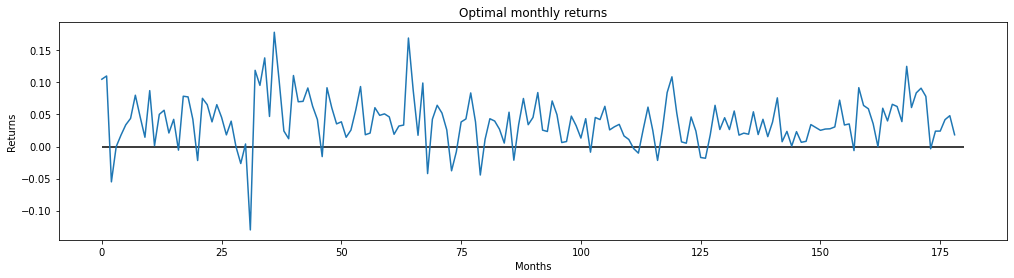

In [17]:
#Plotting the returns. They remain positive, most of the time
df_best.iloc[:,2].plot(figsize = (17,4))
plt.title('Optimal monthly returns')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.hlines(y=0, xmin = 0, xmax = 180)
plt.show()

In [24]:
#An interactive monthly returns plot is given bellow in order to visualize the differences. THe mean here is mostly around zero in constrast
# to the optimal dynamic portfolio
def plot_returns2(i):
    returns.iloc[:,i][::22].plot(figsize = (17,4))
    plt.title(returns.iloc[:,i].name)
    plt.hlines(y=0, xmin = '2006-01-01', xmax = '2021-03-01')
    plt.show()
    

interact(plot_returns2, i=widgets.IntSlider(min=0, max=len(weight1), step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_returns2(i)>